In [71]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from utilsforecast.plotting import plot_series

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
# --NotebookApp.iopub_msg_rate_limit=10000

In [72]:
# Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
# # Y_df = Y_df.query("unique_id in['H1','H2','H3','H4']")
# Y_df.head()

In [73]:
from datasetsforecast.m4 import M4

In [74]:
group = "Daily"
await M4.async_download("data", group=group)
Y_df, *_ = M4.load(directory="data", group=group)

<Axes: ylabel='Frequency'>

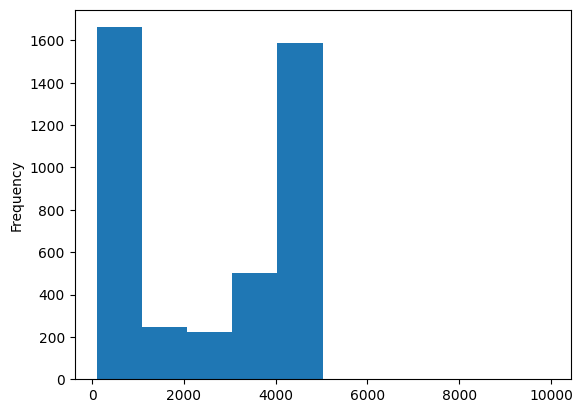

In [75]:
Y_df.unique_id.value_counts().plot(kind="hist")

In [76]:
Y_df["ds"] = Y_df["ds"].astype(int)

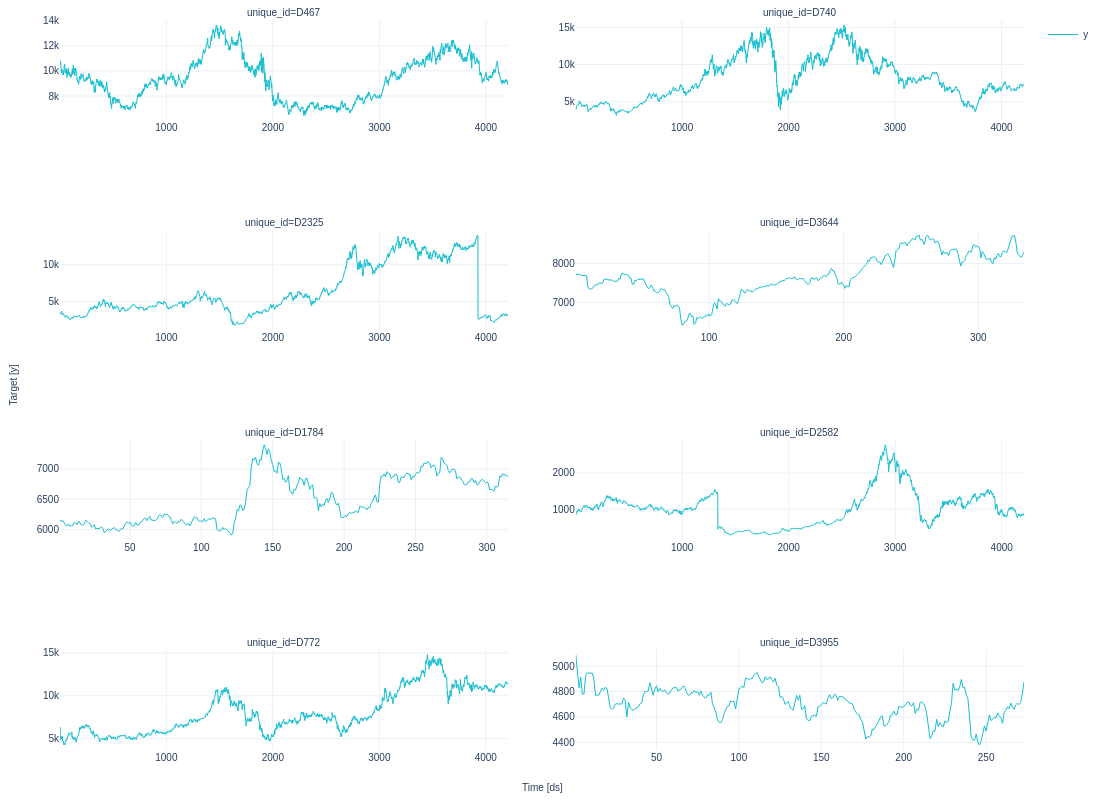

In [79]:
plot_series(Y_df, engine="plotly")

In [4]:
from statsforecast import StatsForecast
from tqdm.autonotebook import tqdm

#### Baseline Models - Classical models for establishing baseline.
- HistoricAverage - 
- Naive
- RandomWalkWithDrift
- SeasonalNaive
- WindowAverage
- SeasonalWindowAverage

#### Exponential Smoothing
- SimpleExponentialSmoothing
- SimpleExponentialSmoothingOptimized	
- SeasonalExponentialSmoothing
- SeasonalExponentialSmoothingOptimized
- Holt
- HoltWinters
- AutoETS
- AutoCES

#### ARIMA Family
- AutoARIMA
- AutoRegressive	

#### Theta Family
- Theta
- OptimizedTheta
- DynamicTheta
- DynamicOptimizedTheta
- AutoTheta

#### Multiple Seasonalities
- MSTL
- AutoMFLES	
- AutoTBATS
#### GARCH and ARCH Models
- GARCH	
- ARCH


#### Sparse or Inttermitent 
- ADIDA
- CrostonClassic	
- CrostonOptimized	
- CrostonSBA
- IMAPA
- TSB

In [80]:
# Import StatsForecast
from statsforecast.core import StatsForecast

# Import necessary models from the statsforecast library
from statsforecast.models import (
    ADIDA,
    ARCH,
    GARCH,
    IMAPA,
    TSB,
    AutoARIMA,
    AutoCES,
    AutoETS,
    AutoMFLES,
    AutoRegressive,
    AutoTBATS,
    AutoTheta,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SeasonalWindowAverage,
    WindowAverage,
)

horizon = 30
season_length = 7

models = [
    HistoricAverage(),
    Naive(),
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=season_length),
    WindowAverage(window_size=season_length),
    SeasonalWindowAverage(window_size=season_length * 7, season_length=season_length),
    AutoCES(season_length=season_length),
    AutoARIMA(),
    AutoRegressive(lags=season_length),
    AutoTheta(season_length=season_length),
    AutoMFLES(test_size=horizon, season_length=season_length, n_windows=3, step_size=horizon),
    AutoTBATS(season_length=season_length),
    GARCH(),
    ARCH(),
    ADIDA(),
    CrostonClassic(),
    CrostonOptimized(),
    CrostonSBA(),
    IMAPA(),
    TSB(alpha_d=0.2, alpha_p=0.2),
    AutoETS(season_length=season_length),
]

sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq=1,
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

In [ ]:
cv_df = sf.cross_validation(df=Y_df, n_windows=3, step_size=horizon, h=horizon)

/home/pranav-pc/.cache/pypoetry/virtualenvs/ts-EBaOKu-T-py3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning:

invalid value encountered in subtract



In [ ]:
from utilsforecast.losses import rmse


def evaluate_cv(cv_df, metric):
    models = cv_df.columns.drop(["unique_id", "ds", "y", "cutoff"]).tolist()
    evals = metric(cv_df, models=models)
    evals["best_model"] = evals[models].idxmin(axis=1)
    return evals


evaluation_df = evaluate_cv(cv_df, rmse)
evaluation_df.head()

In [ ]:
evaluation_df.best_model.value_counts()

In [ ]:
evaluation_df

In [ ]:
evaluation_df.to_csv("evaluation_m4-daily.csv", index=False)

In [ ]:
plot_series(Y_df, cv_df.drop("cutoff", axis=1), engine="plotly")